In [187]:
import numpy as np
import torch

def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [222]:
#### Create adjacency matrix

# Define distance metrics
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y)**2))

def inverse_distance(x, y):
    return 1 / euclidean_distance(x, y)

# Create adjacency matrix function
def create_adjacency_matrix(data, distance_metric):
    n = data.shape[0]
    adjacency_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:  # we don't calculate the distance of the object to itself
                # we extract the position [x, y] for both objects i and j
                position_i = data[i, 1:3]
                position_j = data[j, 1:3]
                adjacency_matrix[i, j] = distance_metric(position_i, position_j)
    return adjacency_matrix

# Validate input
def validate_input(X, adjacency_matrix):
    # X should be a 2D tensor
    assert X.dim() == 2, f"X must be 2D, but got shape {X.shape}"

    # The number of nodes should be the same in X and the adjacency matrix
    assert X.shape[0] == adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Mismatch in number of nodes: got {X.shape[0]} nodes in X, but {adjacency_matrix.shape[0]} nodes in adjacency matrix"

    # The adjacency matrix should be square
    assert adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Adjacency matrix must be square, but got shape {adjacency_matrix.shape}"

    print("All checks passed.")


In [69]:
# Load and examine sample data
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state(X): shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state(y): shape (n_bodies, [x, y])

"""


X, y= load_array('data/task 1/train/trajectory_0.npz', task='task 1')
X = torch.tensor(X, dtype=torch.float32)


In [18]:
# Testing adjacency matrix
adjacency_matrix = create_adjacency_matrix(X, inverse_distance)

In [85]:
# Test network
import torch
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data

class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GraphConv(num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st Graph Convolution layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd Graph Convolution layer
        x = self.conv2(x, edge_index)

        return x


# Convert adjacency matrix to edge_index
# WARNING! This will 'Delete' the distances between the nodes
edge_index = adjacency_matrix.nonzero().t()

# Create a Data object
data = Data(x=X, edge_index=edge_index)

# Create an instance of our GNN
model = SimpleGNN(num_features=5, hidden_channels=32, num_classes=2)

# Pass the graph through the model
out = model(data)

print(out.shape)
edge_index[:, 4]

torch.Size([8, 2])


tensor([0, 5])

In [288]:
# Model Zoo
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, int(hidden_channels/2))

        self.fc = torch.nn.Linear(int(hidden_channels/2), num_classes)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        # Dropout
        x = self.dropout(x)

        # Linear layer
        x = self.fc(x)

        return x

class MinGraphSAGE(torch.nn.Module):
    # FINAL MODEL!
    def __init__(self, num_features, hidden_channels, num_classes):
        super(MinGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)

        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Droput
        x = self.dropout(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)

        return x

from torch_geometric.nn import BatchNorm

class ImprovedGraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(ImprovedGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.batch_norm1 = BatchNorm(hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.batch_norm2 = BatchNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = torch.relu(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)

        return x



In [242]:
# DataLoader

from torch_geometric.data import Dataset, Data, DataLoader

class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 1')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t()

        data = Data(x=X, y=y, edge_index=edge_index)

        return data

filenames = [f'data/task 1/train/trajectory_{i}.npz' for i in range(900)]

# Create two subsets for train/validation split from the filenames list
train_filenames = filenames[:800]
val_filenames = filenames[800:]

train_dataset = MyDataset(root='data/task 1/train', filenames=train_filenames)
train_dataloader = DataLoader(train_dataset, batch_size=32)

# Create validation dataset from val_filenames
val_dataset = MyDataset(root='data/task 1/train', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Prepare for validation data set

test_filenames = [f'data/task 1/test/trajectory_{i}.npz' for i in range(901, 1000)]
test_dataset = MyDataset(root='data/task 1/test', filenames=test_filenames)
test_dataloader = DataLoader(test_dataset, batch_size=32)

Epoch: 1, Training Loss: 5.808894634246826, Val Loss: 6.977245616912842
Epoch: 2, Training Loss: 5.026021480560303, Val Loss: 6.2188232803344725
Epoch: 3, Training Loss: 4.977367401123047, Val Loss: 5.989545631408691
Epoch: 4, Training Loss: 4.816941261291504, Val Loss: 5.792610301971435
Epoch: 5, Training Loss: 4.397088050842285, Val Loss: 5.678466053009033
Epoch: 6, Training Loss: 4.634696960449219, Val Loss: 5.596944160461426
Epoch: 7, Training Loss: 4.536742687225342, Val Loss: 5.503141136169433
Epoch: 8, Training Loss: 4.081517696380615, Val Loss: 5.398542098999023
Epoch: 9, Training Loss: 4.278598785400391, Val Loss: 5.402566738128662
Epoch: 10, Training Loss: 4.463237285614014, Val Loss: 5.324370708465576
Epoch: 11, Training Loss: 4.523837089538574, Val Loss: 5.299742412567139
Epoch: 12, Training Loss: 4.3920159339904785, Val Loss: 5.323873519897461
Epoch: 13, Training Loss: 4.361993312835693, Val Loss: 5.315289897918701
Epoch: 14, Training Loss: 4.4557108879089355, Val Loss: 5.

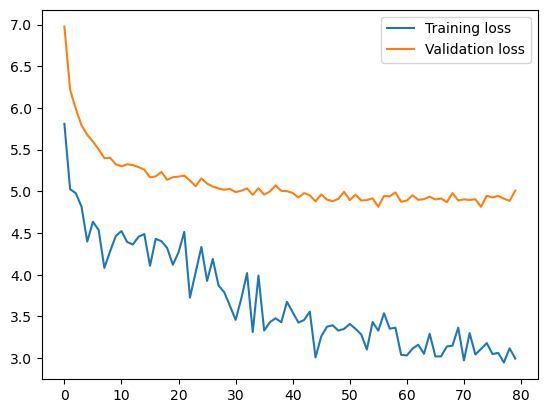

In [290]:
device = "mps"
model = MinGraphSAGE(num_features=5, hidden_channels=64, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

# Store losses
train_losses = []
val_losses = []

epochs = 80

for epoch in range(epochs):  
    # Training
    model.train()
    for batch in train_dataloader:
        batch = batch.to(device)  # move batch to the device
        optimizer.zero_grad()  # set gradients to zero
        out = model(batch)  # forward pass
        loss = criterion(out, batch.y)  # compute loss
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update model parameters
    train_losses.append(loss.item())

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            out = model(batch)
            val_loss += criterion(out, batch.y).item() * batch.num_graphs
        
    val_loss /= len(val_dataset)  # compute average validation loss
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Val Loss: {val_loss}')


# Plot losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [261]:
# Calculate static and linear baselines (formula on ANS)
# THIS IS CORRECT! DO NOT CHANGE!

def static_baseline(X):
    return X[:, 1:3]  # initial x,y coordinates

def linear_baseline(X):
    return X[:, 1:3] + X[:, 3:5] * 5  # initial x,y coordinates plus velocity times time

def compute_baseline_loss(baseline_fn, dataloader):
    total_loss = 0
    criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

    for batch in dataloader:
        batch = batch.to(device)
        predictions = baseline_fn(batch.x).to(device)
        total_loss += criterion(predictions, batch.y).item() * batch.num_graphs

    return total_loss / len(dataloader.dataset)

train_loss_static = compute_baseline_loss(static_baseline, train_dataloader)
train_loss_linear = compute_baseline_loss(linear_baseline, train_dataloader)

val_loss_static = compute_baseline_loss(static_baseline, val_dataloader)
val_loss_linear = compute_baseline_loss(linear_baseline, val_dataloader)

test_loss_static = compute_baseline_loss(static_baseline, test_dataloader)
test_loss_linear = compute_baseline_loss(linear_baseline, test_dataloader)

 # now print out with filler spaces to make it easier to read
print(f'Training Loss   - Static Baseline: {train_loss_static:0.4f}, Linear Baseline: {train_loss_linear:0.4f}')
print(f'Validation Loss - Static Baseline: {val_loss_static:0.4f}, Linear Baseline: {val_loss_linear:0.4f}')
print(f'Test Loss - Static Baseline: {test_loss_static:0.4f}, Linear Baseline: {test_loss_linear:0.4f}')


Training Loss   - Static Baseline: 13.9273, Linear Baseline: 22.0866
Validation Loss - Static Baseline: 13.9548, Linear Baseline: 22.9528
Test Loss - Static Baseline: 11.4824, Linear Baseline: 20.2710


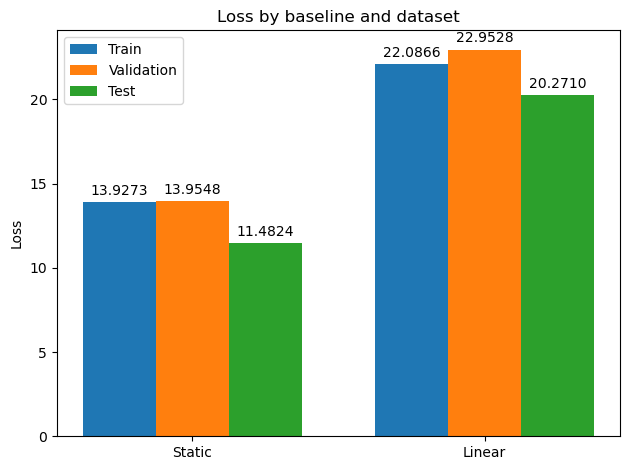

In [266]:
# Create barplot with static and linear baseline losses for train-test-val 3 separate bars

import matplotlib.pyplot as plt
import numpy as np

train_losses = [train_loss_static, train_loss_linear]
val_losses = [val_loss_static, val_loss_linear]
test_losses = [test_loss_static, test_loss_linear]

x = np.arange(len(train_losses))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_losses, width, label='Train')
rects2 = ax.bar(x, val_losses, width, label='Validation')
rects3 = ax.bar(x + width, test_losses, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Loss by baseline and dataset')
ax.set_xticks(x)
ax.set_xticklabels(['Static', 'Linear'])
ax.legend()

# Add numbers on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:  # for each bar
        height = rect.get_height()  # get height of bar
        ax.annotate(f'{height:0.4f}',  # annotate with height
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # put label in the middle of the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Do the autolabel
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Task 2


In [196]:
# Check datashape
X, y= load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')
X.shape, y.shape

((8, 5), (8, 49, 4))

In [214]:
# Model Zoo for TASK 2

from torch_geometric.nn import SAGEConv
import torch.nn as nn

class GraphLSTM(torch.nn.Module):
    # Test MSE: 1.75 Train MSE: 0.40 (100 epochs)
    def __init__(self, num_features, hidden_channels, num_classes, num_time_steps):
        super(GraphLSTM, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels*2, batch_first=True)

        # add a sequential 2 fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels*2, num_classes)
        )
        self.num_time_steps = num_time_steps

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        # LSTM layer
        # Repeat x along a new temporal dimension to create a sequence, with the repeated
        # x as the input at each time step. This is necessary because the LSTM expects
        # input of the form (batch_size, sequence_length, input_size).
        x = x.unsqueeze(1).repeat(1, self.num_time_steps, 1)

        # Pass the sequence of node states through the LSTM.
        # Note that we discard the LSTM's hidden state output, as we are only
        # interested in its output sequences for this application.
        x, _ = self.lstm(x)

        #  Pass it through the fully connected layers
        x = self.fc(x)

        return x

class GraphLSTM2(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_time_steps):
        super(GraphLSTM2, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lstm1 = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels*2, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_channels*2, hidden_size=hidden_channels*2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels*2, num_classes)
        )
        self.num_time_steps = num_time_steps

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = x.unsqueeze(1).repeat(1, self.num_time_steps, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)
        return x

class GraphGRU(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_time_steps):
        super(GraphGRU, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.gru = nn.GRU(input_size=hidden_channels, hidden_size=hidden_channels*2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels*2, num_classes)
        )
        self.num_time_steps = num_time_steps

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = x.unsqueeze(1).repeat(1, self.num_time_steps, 1)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x



In [200]:
# Doing a single forward pass, checking the output shape and MSE
model = GraphLSTM(num_features=5, hidden_channels=32, num_classes=4, num_time_steps=49).to(device)
from torch.nn.functional import mse_loss

# Assume that the load_array function and create_adjacency_matrix function are defined somewhere above.
X, y = load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
edge_index = adjacency_matrix.nonzero().t()

# Put these into a PyTorch Geometric Data object
data = Data(x=X, y=y, edge_index=edge_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# Forward pass
out = model(data)
print(f"Output shape: {out.shape}")

# Calculate MSE loss
loss = mse_loss(out, data.y)
print(f"MSE Loss: {loss.item()}")


Output shape: torch.Size([8, 49, 4])
MSE Loss: 115.92279052734375


In [112]:
# DataLoaders for task 2

class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 2')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)   # y is now a 3D tensor

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t()

        data = Data(x=X, y=y, edge_index=edge_index)  # y is now a 3D tensor

        return data

filenames = [f'data/task 2_3/train/trajectory_{i}.npz' for i in range(900)]
dataset = MyDataset(root='data/task 2_3/train', filenames=filenames)
dataloader = DataLoader(dataset, batch_size=32)

# Prepare for validation data set

val_filenames = [f'data/task 2_3/test/trajectory_{i}.npz' for i in range(901, 1000)]
val_dataset = MyDataset(root='data/task 2_3/test', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=32)

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [190]:
# Calculate baseline losses

def static_baseline(X):
    initial_position = X[:, 1:3]  # initial x,y coordinates
    # Repeat the initial position for each timestep
    return initial_position.unsqueeze(1).repeat(1, 49, 1)  # assuming 49 timesteps

def linear_baseline(X):
    initial_position = X[:, 1:3]  # initial x,y coordinates
    initial_velocity = X[:, 3:5]  # initial velocity
    # Predict position for each timestep using v = u + at
    return initial_position.unsqueeze(1) + initial_velocity.unsqueeze(1) * (torch.arange(49).to(X.device).reshape(1, -1, 1) / 10)  

def compute_baseline_loss(baseline_fn, dataloader):
    total_loss = 0
    criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

    for batch in dataloader:
        batch = batch.to(device)
        predictions = baseline_fn(batch.x).to(device)
        # Only take the position labels for loss calculation
        pos_labels = batch.y[..., :2]
        total_loss += criterion(predictions, pos_labels).item() * batch.num_graphs

    return total_loss / len(dataloader.dataset)

train_loss_static = compute_baseline_loss(static_baseline, dataloader)
train_loss_linear = compute_baseline_loss(linear_baseline, dataloader)

val_loss_static = compute_baseline_loss(static_baseline, val_dataloader)
val_loss_linear = compute_baseline_loss(linear_baseline, val_dataloader)

 # now print out with filler spaces to make it easier to read
print(f'Training Loss   - Static Baseline: {train_loss_static:0.4f}, Linear Baseline: {train_loss_linear:0.4f}')
print(f'Validation Loss - Static Baseline: {val_loss_static:0.4f}, Linear Baseline: {val_loss_linear:0.4f}')


Training Loss   - Static Baseline: 5.0640, Linear Baseline: 6.2776
Validation Loss - Static Baseline: 5.1950, Linear Baseline: 6.5654


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

train_losses = [train_loss_static, train_loss_linear]
val_losses = [val_loss_static, val_loss_linear]
test_losses = [test_loss_static, test_loss_linear]

x = np.arange(len(train_losses))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_losses, width, label='Train')
rects2 = ax.bar(x, val_losses, width, label='Validation')
rects3 = ax.bar(x + width, test_losses, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Loss by baseline and dataset')
ax.set_xticks(x)
ax.set_xticklabels(['Static', 'Linear'])
ax.legend()

# Add numbers on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:  # for each bar
        height = rect.get_height()  # get height of bar
        ax.annotate(f'{height:0.4f}',  # annotate with height
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # put label in the middle of the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Do the autolabel
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

In [223]:
# Training the model
device = "mps" #NOTE: change to cuda or cpu if not apple silicon 
model = GraphLSTM(num_features=5, hidden_channels=32, num_classes=4, num_time_steps=49).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

for epoch in range(50):  # run for 100 epochs
    # Training
    model.train()
    for batch in dataloader:
        batch = batch.to(device)  # move batch to the device
        optimizer.zero_grad()  # set gradients to zero
        out = model(batch)  # forward pass

        # Only take the position predictions (first two dimensions of the last dimension) for loss calculation
        pos_out = out[..., :2]
        pos_labels = batch.y[..., :2]

        loss = criterion(pos_out, pos_labels)  # compute loss
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update model parameters

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            out = model(batch)
            pos_out = out[..., :2]
            pos_labels = batch.y[..., :2]
            val_loss += criterion(pos_out, pos_labels).item() * batch.num_graphs

    val_loss /= len(val_dataset)  # compute average validation loss

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Test Loss: {val_loss}')


Epoch: 1, Training Loss: 4.430367946624756, Test Loss: 4.242196285363399
Epoch: 2, Training Loss: 3.7979485988616943, Test Loss: 3.996108305574668
Epoch: 3, Training Loss: 3.5236783027648926, Test Loss: 3.7076628617566043
Epoch: 4, Training Loss: 3.370070695877075, Test Loss: 3.3932124629165186
Epoch: 5, Training Loss: 3.483266830444336, Test Loss: 3.291827004365247
Epoch: 6, Training Loss: 3.6756067276000977, Test Loss: 3.3507321531122383
Epoch: 7, Training Loss: 2.80039381980896, Test Loss: 3.031314421181727
Epoch: 8, Training Loss: 2.627988576889038, Test Loss: 2.8920218101655593
Epoch: 9, Training Loss: 2.5919442176818848, Test Loss: 2.7613493818225283
Epoch: 10, Training Loss: 2.503917932510376, Test Loss: 2.694690552624789
Epoch: 11, Training Loss: 2.335697650909424, Test Loss: 2.6162538094954058
Epoch: 12, Training Loss: 2.285950183868408, Test Loss: 2.523043711980184
Epoch: 13, Training Loss: 2.161332130432129, Test Loss: 2.499965537678112
Epoch: 14, Training Loss: 2.1222159862

## Misc

Plots, checking errors, tensors, anything

/var/folders/z4/_gr926652s36cq6g6g4hfcdh0000gn/T/ipykernel_55628/1061363973.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', len(y))


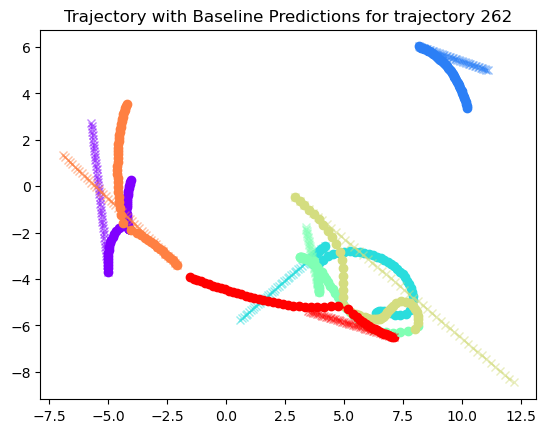

In [220]:
#### Plot a single trajectory
i = np.random.randint(low=0, high=899) # Index of trajectory
X, y= load_array(f'data/task 2_3/train/trajectory_{i}.npz', task='task 2')
# convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Make predictions
from scipy.spatial.distance import pdist, squareform

# WARNING! This redefines the create_adjacency_matrix function from earlier
def create_adjacency_matrix(X):
    # Calculate Euclidean distance
    distances = pdist(X[:, 1:3], metric='euclidean')

    # Convert pairwise distances into a square matrix.
    adjacency_matrix = squareform(distances)

    # Inverse the distances to get inverse distance adjacency
    adjacency_matrix = 1 / (adjacency_matrix + 1e-5)  # add a small value to avoid division by zero

    # Get edge index from adjacency matrix
    edge_index = torch.tensor(np.where(adjacency_matrix != 0), dtype=torch.long)

    return edge_index

edge_index = create_adjacency_matrix(X.numpy())



import matplotlib.pyplot as plt
# Assuming X, y are the tensors to be plotted
# Assuming edge_index is created

data = Data(x=X, y=y, edge_index=edge_index)
data = data.to(device)  # move data to the device where the model is
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for prediction
    prediction = model(data)  # Get prediction

import matplotlib.pyplot as plt

def plot_trajectory_with_baseline(X, y, plot_start=True):
    colors = plt.cm.get_cmap('rainbow', len(y))

    for idx, traj in enumerate(y):
        color = colors(idx)

        if plot_start:
            plt.scatter(X[idx, 1], X[idx, 2], color=color, marker='o')  # plot start positions

        plt.plot(traj[:, 0], traj[:, 1], color=color, linestyle='-', marker='o')  # plot real trajectory

        # linear_baseline: initial x,y coordinates plus velocity times time
        preds = np.zeros_like(traj)
        for t in range(len(preds)):
            preds[t, 0:2] = X[idx, 1:3] + X[idx, 3:5] * t/10

        plt.plot(preds[:, 0], preds[:, 1], color=color, linestyle='--', marker='x', alpha=0.5)  # plot baseline predictions
    # set title for plot
    plt.title(f"Trajectory with Baseline Predictions for trajectory {i}")
    plt.show()

plot_trajectory_with_baseline(X.numpy(), y.numpy())

